# Прогнозирование оттока клиентов телеком компании

Оператор связи хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, оператору нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. 

Задача — обучить модель для прогноза оттока клиентов.

**Описание услуг**

Оператор предоставляет два основных типа услуг:

- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение бывает двух типов: через телефонную линию DSL (англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (англ. fiber optic).

Также абонентам доступен ряд услуг:

- Интернет-безопасность: антивирус (Device Protection) и блокировка опасных сайтов (Online Security);
- Выделенная линия технической поддержки (Tech Support);
- Облачное хранилище файлов для резервного копирования данных (Online Backup);
- Стриминговое телевидение (Streaming TV) и каталог фильмов (Streaming Movies).

За услуги клиенты могут платить ежемесячно или раз в 1–2 года. Доступны различные способы расчёта и возможность получить электронный чек.

**План работы:**

1. Загрузить данные.
2. Выполнить исследовательский анализ и предобработку данных.
3. Объединить таблицы и проанализировать объединенные данные.
4. Обучить модели на объединенных данных.
5. Проверить данные на тестовой выборке. Значение метрики ROC-AUC должно быть не менее 0.85 по ТЗ.
6. Сделать выводы.


<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item">
    
<li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li>

<li><span><a href="#Исследовательский-анализ-и-предобработка-данных" data-toc-modified-id="Исследовательский-анализ-и-предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ и предобработка данных</a></span></li>

<li><span><a href="#Объединение-таблиц" data-toc-modified-id="Объединение-таблиц"><span class="toc-item-num">2&nbsp;&nbsp;</span>Объединение таблиц</a></span></li>

<li><span><a href="#Анализ-объединенных-данных" data-toc-modified-id="Анализ-объединенных-данных"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ объединенных данных</a></span></li>

<li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных</a></span></li>

<li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span></li>
    
<li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели"><span class="toc-item-num">2&nbsp;&nbsp;</span>Тестирование модели</a></span></li>

<li><span><a href="#Общий-вывод-по-работе" data-toc-modified-id="Общий-вывод-по-работе"><span class="toc-item-num">2&nbsp;&nbsp;</span>Общий вывод по работе</a></span></li></ul>


</div>


## Загрузка данных

In [1]:
pip install psycopg2-binary

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install -q phik

In [3]:
!pip install lightgbm

In [4]:
!pip install torch==1.10.0+cpu torchvision==0.11.0+cpu torchaudio==0.10.0 -f https://download.pytorch.org/whl/torch_stable.html --user

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [5]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install skorch

Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine 

import phik
from phik.report import plot_correlation_matrix
from phik import report

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline 
from sklearn.compose import make_column_transformer
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)
from sklearn import preprocessing
from sklearn import utils

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.compose import ColumnTransformer
import lightgbm as lgb
from lightgbm import LGBMClassifier

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [8]:
import skorch
from skorch import NeuralNet
from skorch import NeuralNetClassifier

In [9]:
RANDOM_STATE = 141123

In [10]:
db_config = {
    'user': 'хххххх',# имя пользователя,
    'pwd': 'ххххххх',# пароль,
    'host': 'хххххх',
    'port': хххххх,# порт подключения,
    'db': 'хххххх'# название базы данных,
}
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [11]:
engine = create_engine(connection_string) 

In [12]:
query = '''
SELECT *
FROM telecom.contract;
'''

contract_df = pd.read_sql_query(query, con=engine) 
contract_df

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,2569-WGERO,2019-01-21,None,Two year,Yes,Bank transfer (automatic),21.15,1419.40
7039,6840-RESVB,2019-02-26,None,One year,Yes,Mailed check,84.80,1990.50
7040,2234-XADUH,2019-09-02,None,One year,Yes,Credit card (automatic),103.20,7362.90
7041,4801-JZAZL,2019-06-26,None,Month-to-month,Yes,Electronic check,29.60,346.45


In [13]:
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


In [14]:
query = '''
SELECT *
FROM telecom.personal;
'''

personal_df = pd.read_sql_query(query, con=engine) 
personal_df

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [15]:
personal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [16]:
query = '''
SELECT *
FROM telecom.internet;
'''
internet_df = pd.read_sql_query(query, con=engine)
internet_df

,c1,c2,c3,c4,c5,c6,c7,c8
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
...,...,...,...,...,...,...,...,...
5513,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5514,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5515,4801-JZAZL,DSL,Yes,No,No,No,No,No
5516,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [17]:
#названия столбцов оказалось в первой строке, заменим названия колонок
internet_df = internet_df.rename(columns=internet_df.iloc[0])
internet_df = internet_df.drop (index= 0)
internet_df = internet_df.reset_index(drop=True)
internet_df

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [18]:
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [19]:
query = '''
SELECT *
FROM telecom.phone;
'''
phone_df = pd.read_sql_query(query, con=engine) 
phone_df

,c1,c2
0,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes
...,...,...
6357,2569-WGERO,No
6358,6840-RESVB,Yes
6359,2234-XADUH,Yes
6360,8361-LTMKD,Yes


In [20]:
#названия столбцов оказалось в первой строке, заменим названия колонок
phone_df = phone_df.rename(columns=phone_df.iloc[0])
phone_df = phone_df.drop (index= 0)
phone_df = phone_df.reset_index(drop=True)
phone_df

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


In [21]:
phone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


**Вывод:**

В исходных данных мы имеем 4 таблицы:

- contract_df с информацией о договорах размером 7043 rows × 8 columns;
- personal_df с персональными данными клиентов 7043 rows × 5 columns;
- internet_df информацией об интернет-услугах размером 5518 rows × 8 columns;
- phone_df информацией об услугах телефонии размером 6362 rows × 2 columns.

Информация о договорах актуальна на 1 февраля 2020.

Уже на данном этапе можно предположить, что нам будет не хватать данных, которые действительно влияют на уход клиента, например, количество жалоб на работу сети, количество обращений в тех.поддержку и т.п. Также полезно вести учет причин ухода клиента.

## Исследовательский анализ и предобработка данных

<div class="alert alert-block alert-info">
<b>contract_df</b> 
</div>

Таблица **contract_df** включает в себя стоблцы:

- customerID — ID абонента;
- BeginDate — дата начала действия договора;
- EndDate — дата окончания действия договора;
- Type — тип оплаты: раз в год-два или ежемесячно;
- PaperlessBilling — электронный расчётный лист;
- PaymentMethod — тип платежа;
- MonthlyCharges — расходы за месяц;
- TotalCharges — общие расходы абонента.

7043 rows × 8 columns

In [22]:
contract_df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


In [23]:
contract_df.isna().sum() #проверим количество пропусков по столбцам

customerID             0
BeginDate              0
EndDate             5174
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
dtype: int64

In [24]:
for value in [contract_df]: #выведем на экран уникальные значения в категориальных столбцах
    for column in ['Type', 'PaperlessBilling', 'PaymentMethod']:        
        print('\033[1m' + f'Количество уникальных значений {column}:'+ '\033[0m', value[column].nunique())
        print(sorted(value[column].unique()))
        print()

Количество уникальных значений Type: 3
['Month-to-month', 'One year', 'Two year']

Количество уникальных значений PaperlessBilling: 2
['No', 'Yes']

Количество уникальных значений PaymentMethod: 4
['Bank transfer (automatic)', 'Credit card (automatic)', 'Electronic check', 'Mailed check']



In [25]:
contract_df['customerID'].nunique() #количество договоров

7043

➡️ Очевидно, что пропуски в столбце **EndDate** - это количество договоров, срок которых продолжается.

Пропуски в графе **TotalCharges** скорее всего можно заменить каким-либо значением, проанализируем далее.

Так же, стоит добавить колонку с новым признаком - срок действия договора.

In [26]:
#добавим столбик с целевым признаком
#действие договора закончилось 1, действие договора не закончилось 0
contract_df['EndDate_target'] = contract_df['EndDate']
contract_df['EndDate_target'] = contract_df['EndDate_target'].fillna(0) #заменим пропуски на 0
contract_df.loc[(contract_df['EndDate_target'] != 0), 'EndDate_target'] = 1 #заменим оставшиеся значения на 1

contract_df

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,EndDate_target
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN,0
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN,0
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN,0
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,2019-01-21,None,Two year,Yes,Bank transfer (automatic),21.15,1419.40,0
7039,6840-RESVB,2019-02-26,None,One year,Yes,Mailed check,84.80,1990.50,0
7040,2234-XADUH,2019-09-02,None,One year,Yes,Credit card (automatic),103.20,7362.90,0
7041,4801-JZAZL,2019-06-26,None,Month-to-month,Yes,Electronic check,29.60,346.45,0


In [27]:
contract_df.EndDate_target.value_counts () #проверим, что получилось

0    5174
1    1869
Name: EndDate_target, dtype: int64

In [28]:
#заменим пропуски в стоблце EndDate на последнюю дату актуальности таблицы
contract_df['EndDate'] = contract_df['EndDate'].fillna(pd.to_datetime('2020-02-01', format='%Y.%m.%d'))
contract_df

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,EndDate_target
0,4472-LVYGI,2020-02-01,2020-02-01 00:00:00,Two year,Yes,Bank transfer (automatic),52.55,NaN,0
1,3115-CZMZD,2020-02-01,2020-02-01 00:00:00,Two year,No,Mailed check,20.25,NaN,0
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,5709-LVOEQ,2020-02-01,2020-02-01 00:00:00,Two year,No,Mailed check,80.85,NaN,0
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,2019-01-21,2020-02-01 00:00:00,Two year,Yes,Bank transfer (automatic),21.15,1419.40,0
7039,6840-RESVB,2019-02-26,2020-02-01 00:00:00,One year,Yes,Mailed check,84.80,1990.50,0
7040,2234-XADUH,2019-09-02,2020-02-01 00:00:00,One year,Yes,Credit card (automatic),103.20,7362.90,0
7041,4801-JZAZL,2019-06-26,2020-02-01 00:00:00,Month-to-month,Yes,Electronic check,29.60,346.45,0


In [29]:
#добавим столбец со временем действия контракта в днях
contract_df['EndDate'] = pd.to_datetime(contract_df['EndDate'])
contract_df['BeginDate'] = pd.to_datetime(contract_df['BeginDate'])
contract_df['ContractTerm'] = (contract_df['EndDate'] - contract_df['BeginDate']).dt.days
contract_df

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,EndDate_target,ContractTerm
0,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,0
1,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0,0
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,479
3,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0,0
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,279
...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,2019-01-21,2020-02-01,Two year,Yes,Bank transfer (automatic),21.15,1419.40,0,376
7039,6840-RESVB,2019-02-26,2020-02-01,One year,Yes,Mailed check,84.80,1990.50,0,340
7040,2234-XADUH,2019-09-02,2020-02-01,One year,Yes,Credit card (automatic),103.20,7362.90,0,152
7041,4801-JZAZL,2019-06-26,2020-02-01,Month-to-month,Yes,Electronic check,29.60,346.45,0,220


In [30]:
contract_df['year'] = contract_df['BeginDate'].dt.year #добавим столбец с годом

In [31]:
contract_df[contract_df['TotalCharges'].isna()] #посмотрим на пропуски

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,EndDate_target,ContractTerm,year
0,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,0,2020
1,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0,0,2020
3,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0,0,2020
6,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0,0,2020
7,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0,0,2020
9,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0,0,2020
10,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0,0,2020
11,2775-SEFEE,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),61.90,NaN,0,0,2020
4408,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0,0,2020
5160,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0,0,2020


➡️ Выяснилось, что пропуски в графе **TotalCharges** это договоры, которые заключены непосредствено в день, когда мы сняли данные. Таким образом, по ним еще нет никакой статистики, а значит, эти данные нужно удалить.

In [32]:
contract_df = contract_df.dropna(subset=['TotalCharges']) #удалим пропуски
contract_df = contract_df.reset_index(drop=True)
contract_df

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,EndDate_target,ContractTerm,year
0,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,479,2018
1,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,279,2019
2,9305-CDSKC,2018-12-26,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50,1,310,2018
3,7892-POOKP,2019-04-27,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05,1,188,2019
4,0280-XJGEX,2018-11-13,2019-10-01,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,1,322,2018
...,...,...,...,...,...,...,...,...,...,...,...
7027,2569-WGERO,2019-01-21,2020-02-01,Two year,Yes,Bank transfer (automatic),21.15,1419.40,0,376,2019
7028,6840-RESVB,2019-02-26,2020-02-01,One year,Yes,Mailed check,84.80,1990.50,0,340,2019
7029,2234-XADUH,2019-09-02,2020-02-01,One year,Yes,Credit card (automatic),103.20,7362.90,0,152,2019
7030,4801-JZAZL,2019-06-26,2020-02-01,Month-to-month,Yes,Electronic check,29.60,346.45,0,220,2019


In [33]:
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   datetime64[ns]
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   EndDate_target    7032 non-null   object        
 9   ContractTerm      7032 non-null   int64         
 10  year              7032 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(5)
memory usage: 604.4+ KB


➡️ Мы добавили признак **ContractTerm** - длительность договора в днях и **year** - чтобы посмотреть за какие года у нас есть данные. Так же, мы добавили целевой признак **EndDate_target**.

<font color='blue' size=3><b>Распределение количества заключенных договоров по годам</b></font> 

In [34]:
contract_df.year.value_counts()

2019    5651
2018    1379
2020       2
Name: year, dtype: int64

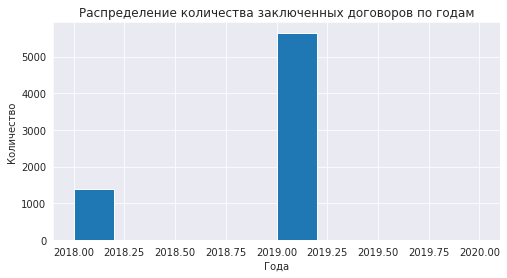

In [35]:
# построим гистограмму
sns.set_style('darkgrid')
contract_df.year.hist(bins=10,figsize=(8,4))
plt.title('Распределение количества заключенных договоров по годам')
plt.xlabel('Года')
plt.ylabel('Количество')
plt.show()

➡️ У нас имеются данные по заключению договоров за 2018 и 2019 года.

<font color='blue' size=3><b>Распределение количества сумм расходов за месяц</b></font> 

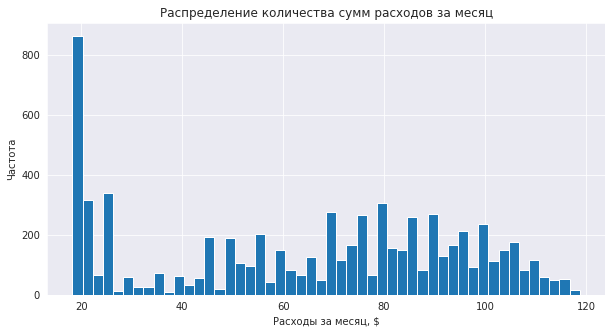

In [36]:
# построим гистограмму
sns.set_style('darkgrid')
contract_df.MonthlyCharges.hist(bins=50,figsize=(10,5))
plt.title('Распределение количества сумм расходов за месяц')
plt.xlabel('Расходы за месяц, $')
plt.ylabel('Частота')
plt.show()

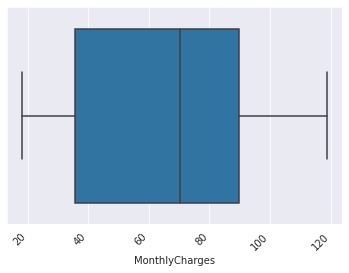

In [37]:
sns.boxplot(x='MonthlyCharges', data=contract_df)
plt.xticks(rotation=45, ha='right');

➡️ Выбросов нет, чаще всего клиенты платят минимальную сумму за месяц, в районе 20 долларов. Второй пик приходится на 80 долларов в месяц.

<font color='blue' size=3><b>Распределение количества суммы общих расходы абонента</b></font> 

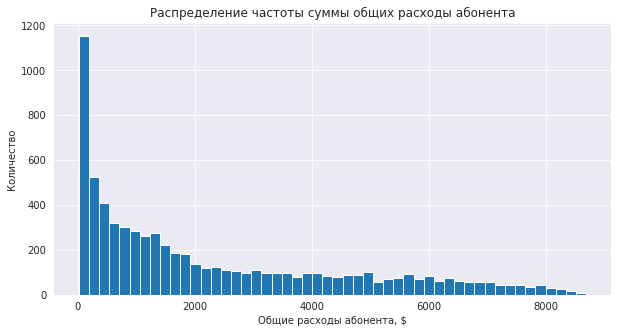

In [38]:
# построим гистограмму
sns.set_style('darkgrid')
contract_df.TotalCharges.hist(bins=50,figsize=(10,5))
plt.title('Распределение частоты суммы общих расходы абонента')
plt.xlabel('Общие расходы абонента, $')
plt.ylabel('Количество')
plt.show()

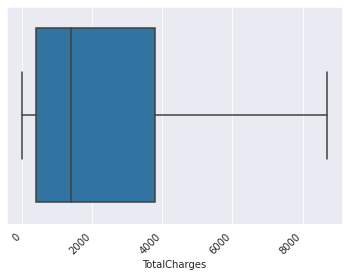

In [39]:
sns.boxplot(x='TotalCharges', data=contract_df)
plt.xticks(rotation=45, ha='right');

➡️ Выбросов нет. Клиентов, заплативших минимальные суммы больше, однако, на мой взгляд, это спорный показатель, так как общая сумма по договору зависит от срока, в течении которого клиент платил.

<font color='blue' size=3><b>Распределение длительности действия договора в днях</b></font> 

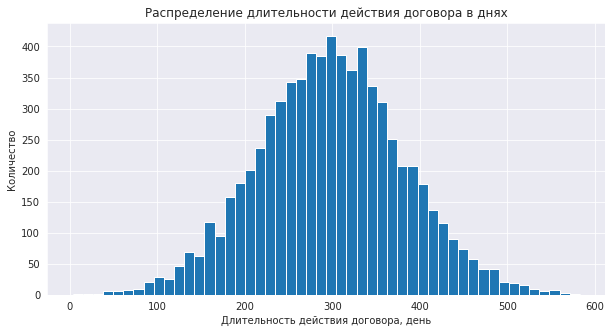

In [40]:
# построим гистограмму
sns.set_style('darkgrid')
contract_df.ContractTerm.hist(bins=50,figsize=(10,5))
plt.title('Распределение длительности действия договора в днях')
plt.xlabel('Длительность действия договора, день')
plt.ylabel('Количество')
plt.show()

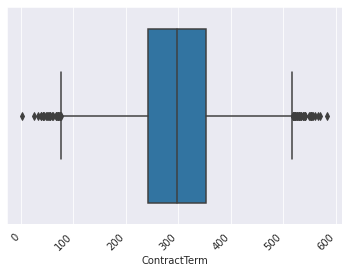

In [41]:
sns.boxplot(x='ContractTerm', data=contract_df)
plt.xticks(rotation=45, ha='right');

➡️ Новый признак **ContractTerm** - срок действия договора - показывает нормальное распределение. Думаю, что мы имеем слишком маленький отрезок времени для адекватного анализа этого признака.

**Вывод:** 

В количественных показателях выбросов не обнаружено. 

Самое большое количество расходов в месяц по договорам - до 20 долларов. 

Клиентов, заплативших минимальные суммы больше, однако, на мой взгляд, это спорный показатель, так как общая сумма по договору зависит от срока, в течении которого клиент платил.

Новый признак ContractTerm показывает нормальное распределение, что может означать случайный характер признака. Думаю, что мы имеем слишком маленький отрезок времени для адекватного анализа этого признака.

<div class="alert alert-block alert-info">
<b>personal_df</b> 
</div>

Таблица **personal_df** включает в себя стоблцы:

- customerID — ID пользователя;
- gender — пол;
- SeniorCitizen — является ли абонент пенсионером;
- Partner — есть ли у абонента супруг или супруга;
- Dependents — есть ли у абонента дети.

7043 rows × 5 columns

In [42]:
personal_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [43]:
personal_df.isna().sum() #проверим количество пропусков по столбцам

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

In [44]:
personal_df.loc[personal_df['SeniorCitizen'] == 0, 'SeniorCitizen'] = 'No'
personal_df.loc[personal_df['SeniorCitizen'] == 1, 'SeniorCitizen'] = 'Yes'

In [45]:
personal_df['customerID'].nunique() #количество 

7043

In [46]:
for value in [personal_df]: # выведем на экран уникальные значения в категориальных столбцах
    for column in ['gender', 'SeniorCitizen', 'Partner', 'Dependents']:        
        print('\033[1m' + f'Количество уникальных значений {column}:'+ '\033[0m', value[column].nunique())
        print(sorted(value[column].unique()))
        print()

Количество уникальных значений gender: 2
['Female', 'Male']

Количество уникальных значений SeniorCitizen: 2
['No', 'Yes']

Количество уникальных значений Partner: 2
['No', 'Yes']

Количество уникальных значений Dependents: 2
['No', 'Yes']



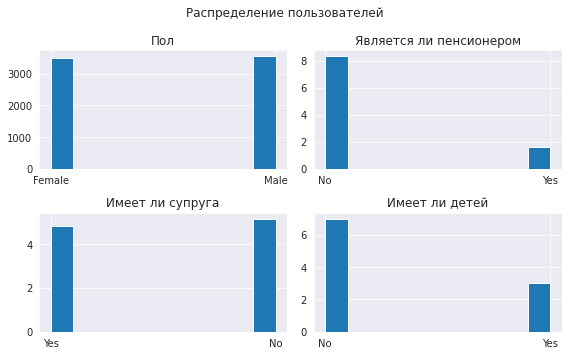

In [47]:
# define grid of plots
fig, axs = plt.subplots(nrows= 2 , ncols= 2, figsize=(8, 5))
fig. suptitle('Распределение пользователей')

axs[0, 0].hist(personal_df.gender, 10, histtype='stepfilled')
axs[0, 0].set_title('Пол')

axs[0, 1].hist(personal_df.SeniorCitizen, 10, density=True, histtype='stepfilled')
axs[0, 1].set_title('Является ли пенсионером')

axs[1, 0].hist(personal_df.Partner, 10, density=True, histtype='stepfilled')
axs[1, 0].set_title('Имеет ли супруга')

axs[1, 1].hist(personal_df.Dependents, 10, density=True, histtype='stepfilled')
axs[1, 1].set_title('Имеет ли детей')

fig.tight_layout()
plt.show()

**Вывод:**

Пропусков и выбросов не обнаружено.

Из графиков видно, что пользователи распределены равномерно по полу и наличию супругов. В основном, пользователи не являются пенсионерами и меньше половины имеют детей.

<div class="alert alert-block alert-info">
<b>internet_df</b> 
</div>

Таблица **internet_df** включает в себя стоблцы:
 
- customerID — ID пользователя;
- InternetService — тип подключения;
- OnlineSecurity — блокировка опасных сайтов;
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;
- DeviceProtection — антивирус;
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов.

5518 rows × 8 columns

In [48]:
internet_df.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [49]:
internet_df['customerID'].nunique() #количество 

5517

In [50]:
for value in [internet_df]: # выведем на экран уникальные значения в категориальных столбцах
    for column in ['InternetService', 'OnlineSecurity', 'OnlineBackup', 
                   'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:        
        print('\033[1m' + f'Количество уникальных значений {column}:'+ '\033[0m', value[column].nunique())
        print(sorted(value[column].unique()))
        print()

Количество уникальных значений InternetService: 2
['DSL', 'Fiber optic']

Количество уникальных значений OnlineSecurity: 2
['No', 'Yes']

Количество уникальных значений OnlineBackup: 2
['No', 'Yes']

Количество уникальных значений DeviceProtection: 2
['No', 'Yes']

Количество уникальных значений TechSupport: 2
['No', 'Yes']

Количество уникальных значений StreamingTV: 2
['No', 'Yes']

Количество уникальных значений StreamingMovies: 2
['No', 'Yes']



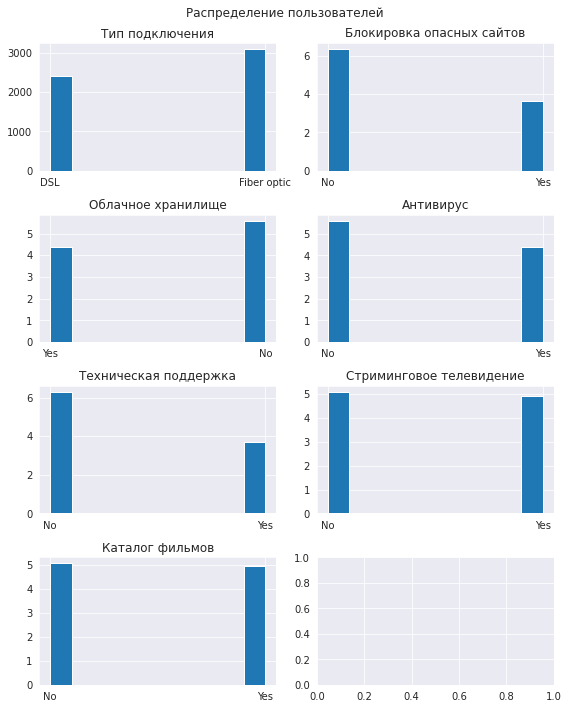

In [51]:
#сетка графиков
fig, axs = plt.subplots(nrows= 4 , ncols= 2, figsize=(8, 10))
fig. suptitle('Распределение пользователей')

axs[0, 0].hist(internet_df.InternetService, 10, histtype='stepfilled')
axs[0, 0].set_title('Тип подключения')

axs[0, 1].hist(internet_df.OnlineSecurity, 10, density=True, histtype='stepfilled')
axs[0, 1].set_title('Блокировка опасных сайтов')

axs[1, 0].hist(internet_df.OnlineBackup, 10, density=True, histtype='stepfilled')
axs[1, 0].set_title('Облачное хранилище')

axs[1, 1].hist(internet_df.DeviceProtection, 10, density=True, histtype='stepfilled')
axs[1, 1].set_title('Антивирус')

axs[2, 0].hist(internet_df.TechSupport, 10, density=True, histtype='stepfilled')
axs[2, 0].set_title('Техническая поддержка')

axs[2, 1].hist(internet_df.StreamingTV, 10, density=True, histtype='stepfilled')
axs[2, 1].set_title('Стриминговое телевидение')

axs[3, 0].hist(internet_df.StreamingMovies, 10, density=True, histtype='stepfilled')
axs[3, 0].set_title('Каталог фильмов')

fig.tight_layout()
plt.show()

**Вывод:**

Большинство клиентов используют оптоволокно для подключения к сети, не используют облачное хранилище, не используют антивирус.

Только в половине случаев используются Блокировка опасных сайтов и Тех.поддержка.



<div class="alert alert-block alert-info">
<b>phone_df</b> 
</div>

Таблица **phone_df** включает в себя стоблцы:

- customerID — ID пользователя;
- MultipleLines — подключение телефона к нескольким линиям одновременно.

6362 rows × 2 columns

In [52]:
phone_df.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [53]:
phone_df['customerID'].nunique() #количество клинетов

6361

In [54]:
for value in [phone_df]: # выведем на экран уникальные значения в категориальных столбцах
    for column in ['MultipleLines']:        
        print('\033[1m' + f'Количество уникальных значений {column}:'+ '\033[0m', value[column].nunique())
        print(sorted(value[column].unique()))
        print()

Количество уникальных значений MultipleLines: 2
['No', 'Yes']



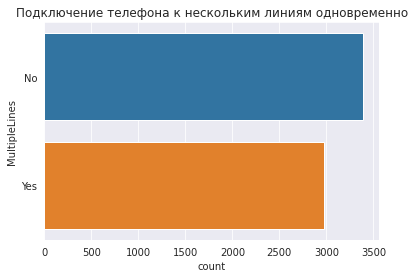

In [55]:
sns.countplot(y='MultipleLines', data=phone_df)
plt.title('Подключение телефона к нескольким линиям одновременно');

**Вывод:**

Пропущенных значений и выбросов не обнаружено.

Большинство клиентов не используют подключение телефона к нескольким линиям одновременно. 

<font color='blue' size=3><b>Выводы:</b></font> 

Исследованы 4 таблицы с данными клинета. Пропусков и выбросов не обнаружено, добавлены два новых признака.

Анализ данных показал, что:

- Самое большое количество расходов в месяц по договорам - до 20 долларов. Общая сумма расходов клиентов по распределению похожа на месячный график. Самое большое количество договоров приходится на сумму около 400 долларов.
- Большинство клиентов используют оптоволокно для подключения к сети, не используются облачное хранилище, не используют антивирус.
- Только в половине случаев используются Блокировка опасных сайтов и Тех.поддержка.
- Пользователи распределены равномерно по полу и наличию супруга. В основном, пользватели не явлюяются пенсионерами и меньше половины имеют детей.
- Большинство клиентов не используют подключение телефона к нескольким линиям одновременно.

## Объединение таблиц

В исходных данных мы имеем 4 таблицы:

- contract_df с информацией о договорах размером 7043 rows × 8 columns;
- personal_df с персональными данными клиентов 7043 rows × 5 columns;
- internet_df информацией об интернет-услугах размером 5518 rows × 8 columns;
- phone_df информацией об услугах телефонии размером 6362 rows × 2 columns.

Объединим таблицы.

In [56]:
data_final = contract_df.merge(personal_df, on='customerID', how='inner')
data_final = data_final.merge(internet_df, on='customerID', how='left')
data_final = data_final.merge(phone_df, on='customerID', how='left')
pd.set_option('display.max_columns', None)
data_final.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,EndDate_target,ContractTerm,year,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,479,2018,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No
1,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,279,2019,Female,No,No,No,Fiber optic,No,No,No,No,No,No,No
2,9305-CDSKC,2018-12-26,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50,1,310,2018,Female,No,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
3,7892-POOKP,2019-04-27,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05,1,188,2019,Female,No,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
4,0280-XJGEX,2018-11-13,2019-10-01,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,1,322,2018,Male,No,No,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes


In [57]:
data_final = data_final.drop(columns=['BeginDate', 'EndDate', 'year'])

In [58]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   Type              7032 non-null   object 
 2   PaperlessBilling  7032 non-null   object 
 3   PaymentMethod     7032 non-null   object 
 4   MonthlyCharges    7032 non-null   float64
 5   TotalCharges      7032 non-null   float64
 6   EndDate_target    7032 non-null   object 
 7   ContractTerm      7032 non-null   int64  
 8   gender            7032 non-null   object 
 9   SeniorCitizen     7032 non-null   object 
 10  Partner           7032 non-null   object 
 11  Dependents        7032 non-null   object 
 12  InternetService   5512 non-null   object 
 13  OnlineSecurity    5512 non-null   object 
 14  OnlineBackup      5512 non-null   object 
 15  DeviceProtection  5512 non-null   object 
 16  TechSupport       5512 non-null   object 


In [59]:
exchange = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
           'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

data_final[exchange] = data_final[exchange].fillna('not_used')

In [60]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   Type              7032 non-null   object 
 2   PaperlessBilling  7032 non-null   object 
 3   PaymentMethod     7032 non-null   object 
 4   MonthlyCharges    7032 non-null   float64
 5   TotalCharges      7032 non-null   float64
 6   EndDate_target    7032 non-null   object 
 7   ContractTerm      7032 non-null   int64  
 8   gender            7032 non-null   object 
 9   SeniorCitizen     7032 non-null   object 
 10  Partner           7032 non-null   object 
 11  Dependents        7032 non-null   object 
 12  InternetService   7032 non-null   object 
 13  OnlineSecurity    7032 non-null   object 
 14  OnlineBackup      7032 non-null   object 
 15  DeviceProtection  7032 non-null   object 
 16  TechSupport       7032 non-null   object 


<font color='blue' size=3><b>Выводы:</b></font> 

Объединили таблицы, заменили пропуски. Получили набор данных из 7032 строк.

## Анализ объединенных данных

<font color='blue' size=3><b>Корреляция Phik correlation</b></font> 

Чтобы учесть в корреляции категориальные переменные, используем корреляцию **Phik correlation**.

In [61]:
data_final_corr = data_final.drop(columns=['customerID'])

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'ContractTerm']


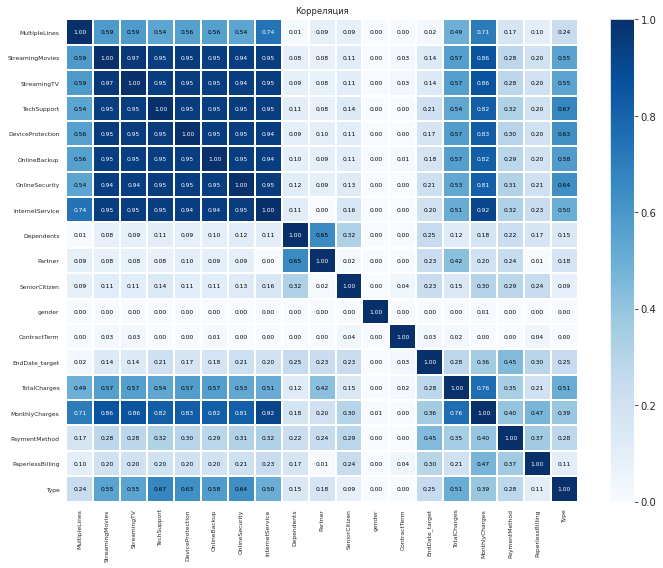

In [62]:
phik_overview = data_final_corr.phik_matrix()
phik_overview.round(2)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, 
                        color_map="Blues", 
                        title=r"Корреляция", 
                        fontsize_factor=0.6, 
                        figsize=(10, 8))
plt.tight_layout()
plt.show();

In [63]:
phik_overview['EndDate_target']

Type                0.251283
PaperlessBilling    0.295194
PaymentMethod       0.448559
MonthlyCharges      0.359623
TotalCharges        0.280973
EndDate_target      1.000000
ContractTerm        0.032889
gender              0.000000
SeniorCitizen       0.232897
Partner             0.232215
Dependents          0.252268
InternetService     0.195860
OnlineSecurity      0.211583
OnlineBackup        0.177165
DeviceProtection    0.170500
TechSupport         0.208763
StreamingTV         0.139025
StreamingMovies     0.139368
MultipleLines       0.021870
Name: EndDate_target, dtype: float64

➡️ Корреляция входных признаков с целевым признаком очень слабая. Максимальная корреляция признака **EndDate_target** с признаком **PaymentMethod**, однако, и это численное значение 0.45 - это слабая корреляция.

<div class="alert alert-block alert-info">
<b>Type</b> - тип оплаты: раз в год-два или ежемесячно
</div>

In [64]:
stat_type = data_final.pivot_table(index='Type', 
                                             columns=["EndDate_target"], 
                                             values='customerID', 
                                             aggfunc=['count'])
stat_type

count      
EndDate_target     0     1
Type                      
Month-to-month  2220  1655
One year        1306   166
Two year        1637    48

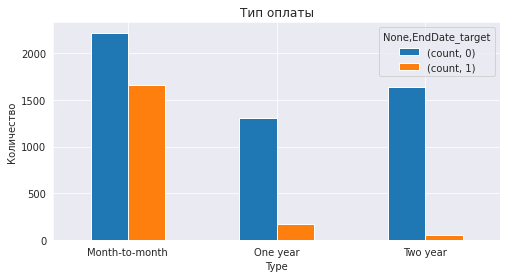

In [65]:
stat_type.plot(figsize=(8,4), grid=True, kind='bar', title="Тип оплаты")
plt.xticks(rotation=0)
plt.ylabel('Количество');

In [66]:
print('Корреляция:', np.round(phik_overview.loc['Type']['EndDate_target'], 2))

Корреляция: 0.25


➡️ Те, кто платит раз в два года или раз в год, разрывает договор реже, чем те кто платит ежемесячно. Корреляция: 0.25 - очень слабая.

<div class="alert alert-block alert-info">
<b>PaperlessBilling</b> - электронный расчётный лист
</div>

In [67]:
stat_pap_bill = data_final.pivot_table(index='PaperlessBilling', 
                                             columns=["EndDate_target"], 
                                             values='customerID', 
                                             aggfunc=['count'])
stat_pap_bill

count      
EndDate_target       0     1
PaperlessBilling            
No                2395   469
Yes               2768  1400

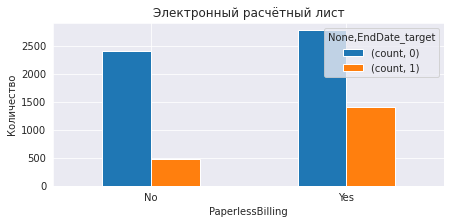

In [68]:
stat_pap_bill.plot(figsize=(7,3), grid=True, kind='bar', title="Электронный расчётный лист")
plt.xticks(rotation=0)
plt.ylabel('Количество');

In [69]:
print('Корреляция:', np.round(phik_overview.loc['PaperlessBilling']['EndDate_target'], 2))

Корреляция: 0.3


➡️ Клиенты, получающие электронные квитанции, чаще разрывают контракт. Корреляция: 0.3 - слабая.

<div class="alert alert-block alert-info">
<b>PaymentMethod</b> - тип платежа
</div>

In [70]:
stat_pay_met = data_final.pivot_table(index='PaymentMethod',
                                             columns=["EndDate_target"],
                                             values='customerID',
                                             aggfunc=['count'])
stat_pay_met

count      
EndDate_target                0     1
PaymentMethod                        
Bank transfer (automatic)  1284   258
Credit card (automatic)    1289   232
Electronic check           1294  1071
Mailed check               1296   308

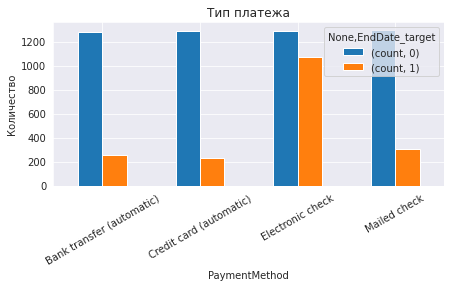

In [71]:
stat_pay_met.plot(figsize=(7,3), grid=True, kind='bar', title="Тип платежа")
plt.xticks(rotation=30)
plt.ylabel('Количество');

In [72]:
print('Корреляция:', np.round(phik_overview.loc['PaymentMethod']['EndDate_target'], 2))

Корреляция: 0.45


➡️ Среди клиентов, разорвавших контракт, большинство расплачиваются кредитной картой. Корреляция: 0.45 - самая высокая из всех признаков, однако, тоже является слабой.

<div class="alert alert-block alert-info">
<b>MonthlyCharges</b> - расходы за месяц
</div>

In [73]:
stat_mon_char = data_final.pivot_table(index='EndDate_target', 
                                             values='MonthlyCharges', 
                                             aggfunc=['mean'])
stat_mon_char

,mean
,MonthlyCharges
EndDate_target,
0,61.307408
1,74.441332


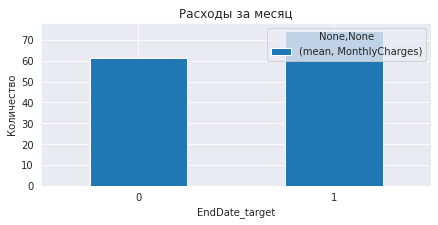

In [74]:
stat_mon_char.plot(figsize=(7,3), grid=True, kind='bar', title="Расходы за месяц")
plt.xticks(rotation=0)
plt.ylabel('Количество');

In [75]:
print('Корреляция:', np.round(phik_overview.loc['MonthlyCharges']['EndDate_target'], 2))

Корреляция: 0.36


➡️ Клиенты, которые расторгли договор, в среднем за месяц платили больше. Корреляция: 0.36 - слабая.

<div class="alert alert-block alert-info">
<b>TotalCharges</b> - общие расходы абонента
</div>

In [76]:
stat_tot_char = data_final.pivot_table(index='EndDate_target', 
                                             values='TotalCharges', 
                                             aggfunc=['mean'])
stat_tot_char

,mean
,TotalCharges
EndDate_target,
0,2555.344141
1,1531.796094


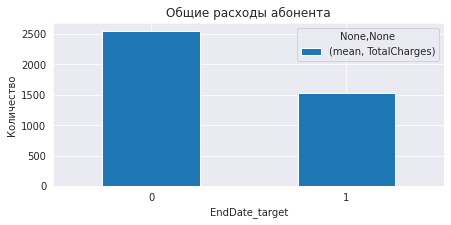

In [77]:
stat_tot_char.plot(figsize=(7,3), grid=True, kind='bar', title="Общие расходы абонента")
plt.xticks(rotation=0)
plt.ylabel('Количество');

In [78]:
print('Корреляция:', np.round(phik_overview.loc['TotalCharges']['EndDate_target'], 2))

Корреляция: 0.28


➡️ Клиенты, которые расторгли договор, имеют в среднем общие расходы меньше. Но эти данные не слишком информативны, так как это, возможно, связано с тем, что клиенты, которые остались, платили дольше по времени. Корреляция: 0.28 - очень слабая.

<div class="alert alert-block alert-info">
<b>ContractTerm</b> - срок действия контракта
</div>

In [79]:
stat_con_term = data_final.pivot_table(index='EndDate_target', 
                                             values='ContractTerm', 
                                             aggfunc=['mean'])
stat_con_term

,mean
,ContractTerm
EndDate_target,
0,297.069533
1,299.982879


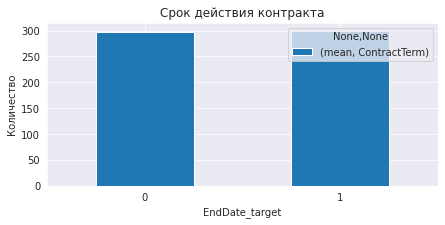

In [80]:
stat_con_term.plot(figsize=(7,3), grid=True, kind='bar', title="Срок действия контракта")
plt.xticks(rotation=0)
plt.ylabel('Количество');

In [81]:
print('Корреляция:', np.round(phik_overview.loc['ContractTerm']['EndDate_target'], 2))

Корреляция: 0.03


➡️ Среднее количество дней, в течение которого длится контракт, примерно одинаковое у обоих типов клиентов. Корреляция: 0.03 - корреляции нет.

<div class="alert alert-block alert-info">
<b>gender</b> - пол
</div>

In [82]:
stat_gender = data_final.pivot_table(index='gender', 
                                             columns=["EndDate_target"], 
                                             values='customerID', 
                                             aggfunc=['count'])
stat_gender

count     
EndDate_target     0    1
gender                   
Female          2544  939
Male            2619  930

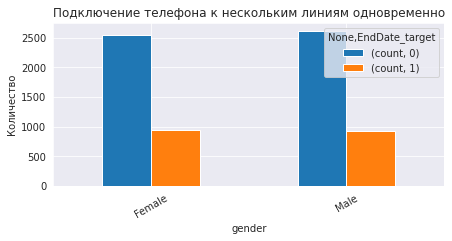

In [83]:
stat_gender.plot(figsize=(7,3), grid=True, kind='bar', 
                  title="Подключение телефона к нескольким линиям одновременно")
plt.xticks(rotation=30)
plt.ylabel('Количество');

In [84]:
print('Корреляция:', np.round(phik_overview.loc['gender']['EndDate_target'], 2))

Корреляция: 0.0


➡️ Корреляции нет.

<div class="alert alert-block alert-info">
<b>SeniorCitizen</b> - является ли абонент пенсионером
</div>

In [85]:
stat_sen_cit = data_final.pivot_table(index='SeniorCitizen', 
                                             columns=["EndDate_target"], 
                                             values='customerID', 
                                             aggfunc=['count'])
stat_sen_cit

count      
EndDate_target     0     1
SeniorCitizen             
No              4497  1393
Yes              666   476

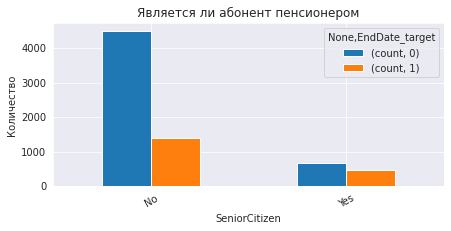

In [86]:
stat_sen_cit.plot(figsize=(7,3), grid=True, kind='bar', 
                  title="Является ли абонент пенсионером")
plt.xticks(rotation=30)
plt.ylabel('Количество');

In [87]:
print('Корреляция:', np.round(phik_overview.loc['SeniorCitizen']['EndDate_target'], 2))

Корреляция: 0.23


➡️ Пенсионеров среди клиентов мало. Корреляция: 0.23 - очень слабая.

<div class="alert alert-block alert-info">
<b>Partner</b> - есть ли у абонента супруг или супруга
</div>

In [88]:
stat_par = data_final.pivot_table(index='Partner', 
                                             columns=["EndDate_target"], 
                                             values='customerID', 
                                             aggfunc=['count'])
stat_par

count      
EndDate_target     0     1
Partner                   
No              2439  1200
Yes             2724   669

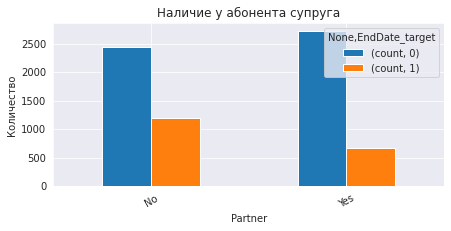

In [89]:
stat_par.plot(figsize=(7,3), grid=True, kind='bar', 
                  title="Наличие у абонента супруга")
plt.xticks(rotation=30)
plt.ylabel('Количество');

In [90]:
print('Корреляция:', np.round(phik_overview.loc['Partner']['EndDate_target'], 2))

Корреляция: 0.23


➡️ Клиентов, имеющих супруга, больше среди тех, кто остался клиентом компании. Тогда как среди тех, кто расторг договор, больше клиентов, которые не имеют супруга. Корреляция: 0.23 - очень слабая.

<div class="alert alert-block alert-info">
<b>Dependents</b> - есть ли у абонента дети
</div>

In [91]:
stat_dep = data_final.pivot_table(index='Dependents', 
                                             columns=["EndDate_target"], 
                                             values='customerID', 
                                             aggfunc=['count'])
stat_dep

count      
EndDate_target     0     1
Dependents                
No              3390  1543
Yes             1773   326

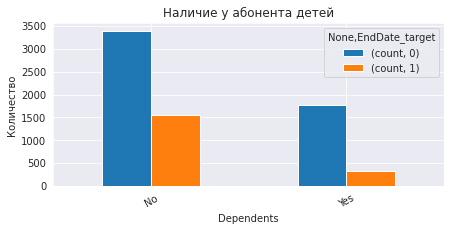

In [92]:
stat_dep.plot(figsize=(7,3), grid=True, kind='bar', 
                  title="Наличие у абонента детей")
plt.xticks(rotation=30)
plt.ylabel('Количество');

In [93]:
print('Корреляция:', np.round(phik_overview.loc['Dependents']['EndDate_target'], 2))

Корреляция: 0.25


➡️ Клиентов, у которых есть дети, меньше. Корреляция: 0.25 - очень слабая.

<div class="alert alert-block alert-info">
<b>InternetService</b> - тип подключения
</div>

In [94]:
stat_int_ser = data_final.pivot_table(index='InternetService', 
                                             columns=["EndDate_target"], 
                                             values='customerID', 
                                             aggfunc=['count'])
stat_int_ser

count      
EndDate_target      0     1
InternetService            
DSL              1957   459
Fiber optic      1799  1297
not_used         1407   113

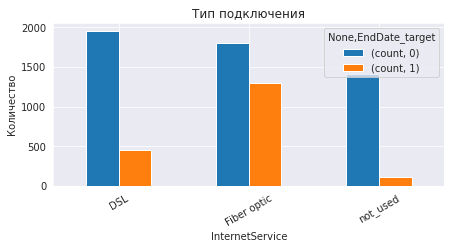

In [95]:
stat_int_ser.plot(figsize=(7,3), grid=True, kind='bar', 
                  title="Тип подключения")
plt.xticks(rotation=30)
plt.ylabel('Количество');

In [96]:
print('Корреляция:', np.round(phik_overview.loc['InternetService']['EndDate_target'], 2))

Корреляция: 0.2


➡️ Среди клиентов, которые покинули компанию, больше тех, которые используют оптоволоконный тип подключения. Возможно, есть какая-то проблема с этом типом подключения. Среди тех, кто остался, больше тех, которые используют DSL. Корреляция: 0.2 - очень слабая.

<div class="alert alert-block alert-info">
<b>OnlineSecurity</b> - блокировка опасных сайтов
</div>

In [97]:
stat_on_sec = data_final.pivot_table(index='OnlineSecurity', 
                                             columns=["EndDate_target"], 
                                             values='customerID', 
                                             aggfunc=['count'])
stat_on_sec

count      
EndDate_target     0     1
OnlineSecurity            
No              2036  1461
Yes             1720   295
not_used        1407   113

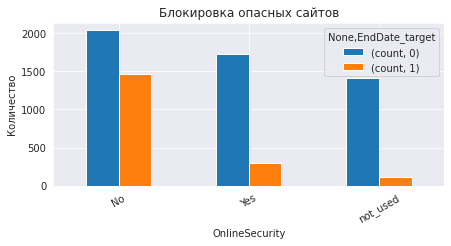

In [98]:
stat_on_sec.plot(figsize=(7,3), 
                 grid=True, 
                 kind='bar', 
                 title="Блокировка опасных сайтов")
plt.xticks(rotation=30)
plt.ylabel('Количество');

In [99]:
print('Корреляция:', np.round(phik_overview.loc['OnlineSecurity']['EndDate_target'], 2))

Корреляция: 0.21


➡️ Корреляция: 0.2 - очень слабая.

<div class="alert alert-block alert-info">
<b>OnlineBackup</b> - облачное хранилище файлов для резервного копирования данных
</div>

In [100]:
stat_on_back = data_final.pivot_table(index='OnlineBackup', 
                                             columns=["EndDate_target"], 
                                             values='customerID', 
                                             aggfunc=['count'])
stat_on_back

count      
EndDate_target     0     1
OnlineBackup              
No              1854  1233
Yes             1902   523
not_used        1407   113

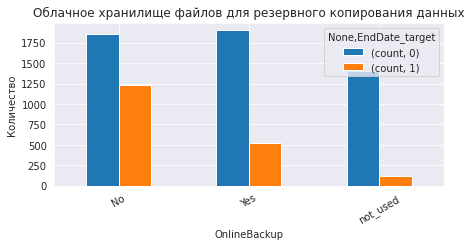

In [101]:
stat_on_back.plot(figsize=(7,3), 
                  grid=True, 
                  kind='bar', 
                  title="Облачное хранилище файлов для резервного копирования данных")
plt.xticks(rotation=30)
plt.ylabel('Количество');

In [102]:
print('Корреляция:', np.round(phik_overview.loc['OnlineBackup']['EndDate_target'], 2))

Корреляция: 0.18


➡️ Корреляция: 0.18 - очень слабая.

<div class="alert alert-block alert-info">
<b>DeviceProtection</b> - антивирус
</div>

In [103]:
stat_dev_pro = data_final.pivot_table(index='DeviceProtection', 
                                             columns=["EndDate_target"], 
                                             values='customerID', 
                                             aggfunc=['count'])
stat_dev_pro

count      
EndDate_target       0     1
DeviceProtection            
No                1883  1211
Yes               1873   545
not_used          1407   113

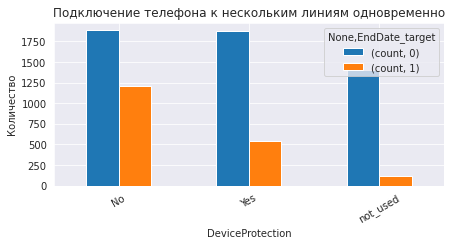

In [104]:
stat_dev_pro.plot(figsize=(7,3), 
                  grid=True, 
                  kind='bar', 
                  title="Подключение телефона к нескольким линиям одновременно")
plt.xticks(rotation=30)
plt.ylabel('Количество');

In [105]:
print('Корреляция:', np.round(phik_overview.loc['DeviceProtection']['EndDate_target'], 2))

Корреляция: 0.17


➡️ Клиенты, которые пользуются подключением телефона к нескольким линиям одновременно, реже уходят. Корреляция: 0.17 - практически нет.

<div class="alert alert-block alert-info">
<b>TechSupport</b> - выделенная линия технической поддержки
</div>

In [106]:
stat_tec_sup = data_final.pivot_table(index='TechSupport', 
                                             columns=["EndDate_target"], 
                                             values='customerID', 
                                             aggfunc=['count'])
stat_tec_sup

count      
EndDate_target     0     1
TechSupport               
No              2026  1446
Yes             1730   310
not_used        1407   113

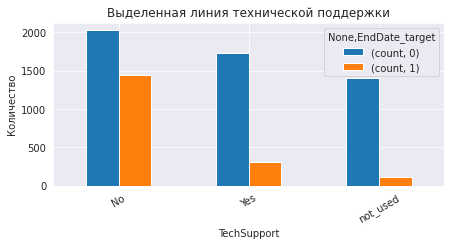

In [107]:
stat_tec_sup.plot(figsize=(7,3), grid=True, kind='bar', 
                  title="Выделенная линия технической поддержки")
plt.xticks(rotation=30)
plt.ylabel('Количество');

In [108]:
print('Корреляция:', np.round(phik_overview.loc['TechSupport']['EndDate_target'], 2))

Корреляция: 0.21


➡️ Клиенты, которые пользуются выделенной линией технической поддержки, реже уходят. Корреляция: 0.21 - слабая.

<div class="alert alert-block alert-info">
<b>StreamingTV</b> - стриминговое телевидение
</div>

In [109]:
stat_str_tv = data_final.pivot_table(index='StreamingTV', 
                                             columns=["EndDate_target"], 
                                             values='customerID', 
                                             aggfunc=['count'])
stat_str_tv

count     
EndDate_target     0    1
StreamingTV              
No              1867  942
Yes             1889  814
not_used        1407  113

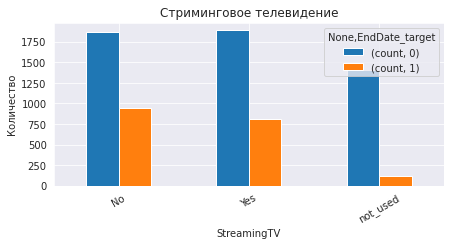

In [110]:
stat_str_tv.plot(figsize=(7,3), 
                 grid=True, 
                 kind='bar', 
                 title="Стриминговое телевидение")
plt.xticks(rotation=30)
plt.ylabel('Количество');

In [111]:
print('Корреляция:', np.round(phik_overview.loc['StreamingTV']['EndDate_target'], 2))

Корреляция: 0.14


➡️ Корреляция: 0.14 - отсутствует.

<div class="alert alert-block alert-info">
<b>StreamingMovies</b> - каталог фильмов
</div>

In [112]:
stat_str_mov = data_final.pivot_table(index='StreamingMovies', 
                                             columns=["EndDate_target"], 
                                             values='customerID', 
                                             aggfunc=['count'])
stat_str_mov

count     
EndDate_target      0    1
StreamingMovies           
No               1843  938
Yes              1913  818
not_used         1407  113

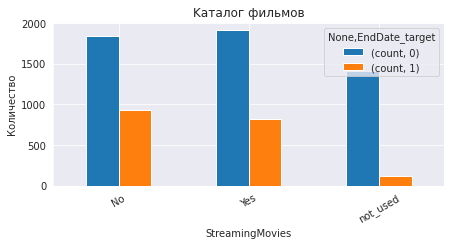

In [113]:
stat_str_mov.plot(figsize=(7,3), 
                  grid=True, 
                  kind='bar', 
                  title="Kаталог фильмов")
plt.xticks(rotation=30)
plt.ylabel('Количество');

In [114]:
print('Корреляция:', np.round(phik_overview.loc['StreamingMovies']['EndDate_target'], 2))

Корреляция: 0.14


➡️ Корреляция: 0.14 - отстутствуют.

<div class="alert alert-block alert-info">
<b>MultipleLines</b> - подключение телефона к нескольким линиям одновременно
</div>

In [115]:
stat_mul_lin = data_final.pivot_table(index='MultipleLines', 
                                             columns=["EndDate_target"], 
                                             values='customerID', 
                                             aggfunc=['count'])
stat_mul_lin

count     
EndDate_target     0    1
MultipleLines            
No              2536  849
Yes             2117  850
not_used         510  170

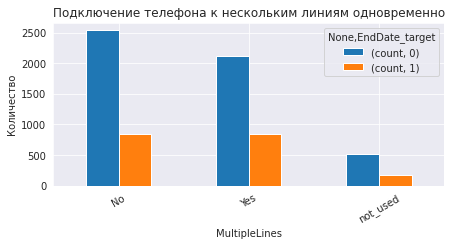

In [116]:
stat_mul_lin.plot(figsize=(7,3), 
                  grid=True, 
                  kind='bar', 
                  title="Подключение телефона к нескольким линиям одновременно")
plt.xticks(rotation=30)
plt.ylabel('Количество');

In [117]:
print('Корреляция:', np.round(phik_overview.loc['MultipleLines']['EndDate_target'], 2))

Корреляция: 0.02


➡️ Корреляция: 0.02 - отсутствует.

<font color='blue' size=3><b>Выводы:</b></font> 
    
Корреляция целевого признака с входными признаками очень низкое. Максимальную корреляцию имеет признак PaymentMethod, однако даже эта корреляция является очень слабой - 0.45.

Анализ данных выявил следующие зависимости:

- Клиенты, которые платят раз в два года или раз в год, разрывают договор реже, чем те кто платит ежемесячно.
- Клиенты, получающие электронные квитанции, чаще разрывают контракт.
- Среди клиентов, разорвавших контракт, большинство расплачиваются кредитной картой.
- Клиенты, которые расторгли договор, в среднем за месяц платили больше.
- Клиенты, которые расторгли договор, имеют общие расходы меньше. Но эти данные не сишком информативны, так как это, возможно, связано с тем, что клиенты, которые остались платили дольше по времени.
- Среднее количество дней, в течении которого длится контракт примерно одинаковое у обоих типов клиентов. 
- Пенсионеров среди клиентов мало.
- Клиентов, имеющих супруга больше среди тех, кто остался клиентом компании. Тогда как среди тех, кто расторг договор, больше клиентов, которые не имеют супруга.
- Клиентов, у которых есть дети, меньше. 
- Среди клиентов, которые покинули компанию, больше тех, которые используют оптоволоконный тип подключения. Возможно, есть какая-то проблема с этом типом подключения. Среди тех, кто остался, больше тех, которые используют DSL. 
- Клиенты, которые пользуются подключением телефона к нескольким линиям одновременно, реже уходят.
- Клиенты, которые пользуются выделенной линии технической поддержки, реже уходят.

## Подготовка данных

In [118]:
data_final.head(3)

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,EndDate_target,ContractTerm,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,1,479,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No
1,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,1,279,Female,No,No,No,Fiber optic,No,No,No,No,No,No,No
2,9305-CDSKC,Month-to-month,Yes,Electronic check,99.65,820.50,1,310,Female,No,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes


Мы получили общую таблицу из 19 столбцов. 

- customerID - **удалим**, не несет никакой информации для дальнейшего обучения;
- Type — тип оплаты: раз в год-два или ежемесячно;
- PaperlessBilling — электронный расчётный лист;
- PaymentMethod — тип платежа;
- MonthlyCharges — расходы за месяц;
- TotalCharges — общие расходы абонента.
- EndDate_target - целевой признак, ушел клиент или нет
- ContractTerm - срок действия контракта - новый признак - удалили все лишние столбцы с датами;
- gender — пол **удалим**, так как корреляция нулевая;
- SeniorCitizen — является ли абонент пенсионером;
- Partner — есть ли у абонента супруг или супруга;
- Dependents — есть ли у абонента дети. 
- InternetService — тип подключения;
- OnlineSecurity — блокировка опасных сайтов;
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;
- DeviceProtection — антивирус;
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов.
- MultipleLines — подключение телефона к нескольким линиям одновременно **удалим**, так как корреляции нет.

In [119]:
data_final = data_final.drop(columns=['customerID', 'gender', 'MultipleLines'])

In [120]:
data_final.head(3)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,EndDate_target,ContractTerm,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,Month-to-month,Yes,Mailed check,53.85,108.15,1,479,No,No,No,DSL,Yes,Yes,No,No,No,No
1,Month-to-month,Yes,Electronic check,70.70,151.65,1,279,No,No,No,Fiber optic,No,No,No,No,No,No
2,Month-to-month,Yes,Electronic check,99.65,820.50,1,310,No,No,No,Fiber optic,No,No,Yes,No,Yes,Yes


In [121]:
#выделим признаки
features = data_final.drop(['EndDate_target'], axis=1)
target = data_final['EndDate_target']
print(features.shape)
print(target.shape)

(7032, 16)
(7032,)


In [122]:
#разобъем на выборки
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                            test_size=0.25,
                                                                            shuffle=True,
                                                                            random_state=RANDOM_STATE)

print(features_train.shape, features_test.shape, target_train.shape, target_test.shape)

(5274, 16) (1758, 16) (5274,) (1758,)


In [123]:
categorical_columns = ['Type', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen', 'Partner',
                      'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                      'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
numeric_columns = ['MonthlyCharges', 'TotalCharges', 'ContractTerm']

In [124]:
#пайплайн
col_transformer_ohe = make_column_transformer(
    (OneHotEncoder(drop='first', handle_unknown='error'), categorical_columns),
    (StandardScaler(), numeric_columns),
    remainder='passthrough')

col_transformer_oe = make_column_transformer(
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_columns),
    remainder='passthrough')

➡️ Для «деревянных» моделей лучше использовать порядковое кодирование, так как они заметно быстрее обучаются на меньшем количестве признаков и не теряют в качестве. Но для линейных моделей (в том числе логистической регрессии) порядковое кодирование не подходит, потому что задает приоритет признакам, которого в природе данных нет. Также для «деревянных» классификаторов масштабирование совсем не обязательно. Но для линейных моделей наоборот, может заметно улучшить метрики.

<font color='blue' size=3><b>Выводы:</b></font> 

Мы удалили из данных лишние столбцы, развелили выборки на тренировочную и тестовую, создали пайплайн для использования разной обработки данных для разных моделей.

## Обучение моделей

<font color='blue' size=3><b>Модель LogisticRegression</b></font> 

In [129]:
model_lr = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')
pipeline_lr = make_pipeline(col_transformer_ohe, model_lr)

In [130]:
target_train.isna().sum()

0

In [131]:
%%time
params_lr = {
            'logisticregression__penalty': ['l1', 'l2'],
            'logisticregression__C': [1.0, 10.0, 100.0]
}
grid_lr = GridSearchCV(pipeline_lr, param_grid=params_lr, cv=3, scoring='roc_auc')
grid_lr.fit(features_train, target_train.astype(int)) 
grid_lr.best_params_

CPU times: user 2.39 s, sys: 1.38 s, total: 3.77 s
Wall time: 3.76 s


{'logisticregression__C': 1.0, 'logisticregression__penalty': 'l1'}

In [132]:
print('ROC-AUC на тренировочной выборке:', round(grid_lr.best_score_, 2))

ROC-AUC на тренировочной выборке: 0.83


<font color='blue' size=3><b>Модель DecisionTreeClassifier</b></font> 

In [133]:
model_dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
pipeline_dt = make_pipeline(col_transformer_oe, model_dt)

In [134]:
parametrs = { 'decisiontreeclassifier__max_depth': range (1,13, 2),
              'decisiontreeclassifier__min_samples_leaf': range (1,8),
              'decisiontreeclassifier__min_samples_split': range (2,10,2) }

In [135]:
%%time
grid_dt = GridSearchCV(pipeline_dt, parametrs, cv=3, scoring='roc_auc')
grid_dt.fit(features_train, target_train.astype(int))
grid_dt.best_params_

CPU times: user 21.1 s, sys: 44.5 ms, total: 21.2 s
Wall time: 21.6 s


{'decisiontreeclassifier__max_depth': 5,
 'decisiontreeclassifier__min_samples_leaf': 5,
 'decisiontreeclassifier__min_samples_split': 2}

In [136]:
print('ROC-AUC на тренировочной выборке:', round(grid_dt.best_score_, 2))

ROC-AUC на тренировочной выборке: 0.82


<font color='blue' size=3><b>Модель RandomForestClassifier</b></font> 

In [137]:
model_rf = RandomForestClassifier(random_state=RANDOM_STATE)
pipeline_rf = make_pipeline(col_transformer_oe, model_rf)

In [138]:
params_rf = {
    'randomforestclassifier__n_estimators': [10, 20, 50],
    'randomforestclassifier__max_depth': [4, 10, 20]
}

In [139]:
%%time
grid_rf = GridSearchCV(pipeline_rf, params_rf, cv=3, scoring='roc_auc')
grid_rf.fit(features_train, target_train.astype(int))
grid_rf.best_params_

CPU times: user 3.63 s, sys: 9.73 ms, total: 3.64 s
Wall time: 3.65 s


{'randomforestclassifier__max_depth': 4,
 'randomforestclassifier__n_estimators': 50}

In [140]:
print('ROC-AUC на тренировочной выборке:', round(grid_rf.best_score_, 2))

ROC-AUC на тренировочной выборке: 0.83


<font color='blue' size=3><b>Модель CatBoostClassifier</b></font> 

In [141]:
cat_features = features.select_dtypes(include='object').columns.to_list()

In [142]:
model_cb = CatBoostClassifier(loss_function="Logloss", iterations=100, learning_rate=0.1, 
                              random_state=RANDOM_STATE) 

In [143]:
param_cat = {'depth':[5,10],
             'l2_leaf_reg': [0.3, 2]
            }

In [144]:
%%time
grid_cb = GridSearchCV(model_cb, param_cat, cv=3, scoring='roc_auc')
grid_cb.fit(features_train, target_train.astype(int), cat_features=cat_features, verbose=100)
grid_cb.best_params_

0:	learn: 0.6592764	total: 51.6ms	remaining: 5.1s
99:	learn: 0.3817602	total: 285ms	remaining: 0us
0:	learn: 0.6595284	total: 3.09ms	remaining: 306ms
99:	learn: 0.3806294	total: 280ms	remaining: 0us
0:	learn: 0.6598256	total: 3.11ms	remaining: 308ms
99:	learn: 0.3854190	total: 250ms	remaining: 0us
0:	learn: 0.6608130	total: 5.2ms	remaining: 515ms
99:	learn: 0.3910534	total: 241ms	remaining: 0us
0:	learn: 0.6609305	total: 3.4ms	remaining: 337ms
99:	learn: 0.3920764	total: 240ms	remaining: 0us
0:	learn: 0.6612329	total: 3.24ms	remaining: 321ms
99:	learn: 0.3958122	total: 246ms	remaining: 0us
0:	learn: 0.6541955	total: 18.5ms	remaining: 1.83s
99:	learn: 0.2591668	total: 1.24s	remaining: 0us
0:	learn: 0.6536408	total: 16.7ms	remaining: 1.66s
99:	learn: 0.2728472	total: 1.07s	remaining: 0us
0:	learn: 0.6564957	total: 15.1ms	remaining: 1.49s
99:	learn: 0.2660438	total: 1.11s	remaining: 0us
0:	learn: 0.6601945	total: 15.7ms	remaining: 1.55s
99:	learn: 0.3255407	total: 1.14s	remaining: 0us
0:	

{'depth': 5, 'l2_leaf_reg': 2}

In [145]:
print('ROC-AUC на тренировочной выборке:', round(grid_cb.best_score_, 2))

ROC-AUC на тренировочной выборке: 0.84


<font color='blue' size=3><b>Модель LGBMRegressor</b></font> 

In [146]:
model_lgb = LGBMClassifier(random_state=RANDOM_STATE)
pipeline_lgb = make_pipeline(col_transformer_ohe, model_lgb)

In [147]:
params_lgb = {
    'lgbmclassifier__num_leaves': [2,5,10], 
    'lgbmclassifier__nnum_iterations': [2,5]
}

In [148]:
%%time
grid_lgb = GridSearchCV(pipeline_lgb, params_lgb, cv=3, scoring='roc_auc', verbose=0)
grid_lgb.fit(features_train, target_train.astype(int))
grid_lgb.best_params_

[LightGBM] [Warning] Unknown parameter: nnum_iterations
[LightGBM] [Warning] Unknown parameter: nnum_iterations
[LightGBM] [Warning] Unknown parameter: nnum_iterations
[LightGBM] [Warning] Unknown parameter: nnum_iterations
[LightGBM] [Warning] Unknown parameter: nnum_iterations
[LightGBM] [Warning] Unknown parameter: nnum_iterations
[LightGBM] [Warning] Unknown parameter: nnum_iterations
[LightGBM] [Warning] Unknown parameter: nnum_iterations
[LightGBM] [Warning] Unknown parameter: nnum_iterations
[LightGBM] [Warning] Unknown parameter: nnum_iterations
[LightGBM] [Warning] Unknown parameter: nnum_iterations
[LightGBM] [Warning] Unknown parameter: nnum_iterations
[LightGBM] [Warning] Unknown parameter: nnum_iterations
[LightGBM] [Warning] Unknown parameter: nnum_iterations
[LightGBM] [Warning] Unknown parameter: nnum_iterations
[LightGBM] [Warning] Unknown parameter: nnum_iterations
[LightGBM] [Warning] Unknown parameter: nnum_iterations
[LightGBM] [Warning] Unknown parameter: nnum_ite

{'lgbmclassifier__nnum_iterations': 2, 'lgbmclassifier__num_leaves': 2}

In [149]:
print('ROC-AUC на тренировочной выборке:', round(grid_lgb.best_score_, 2))

ROC-AUC на тренировочной выборке: 0.84


<font color='blue' size=3><b>Нейронная сеть Net</b></font> 

In [150]:
categorical_columns = ['Type', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen', 'Partner',
                      'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                      'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
numeric_columns = ['MonthlyCharges', 'TotalCharges', 'ContractTerm']

In [151]:
col_transformer = ColumnTransformer(
                        transformers=[
                            ('scaler', StandardScaler(), numeric_columns),
                            ('ohe', OneHotEncoder(sparse=False), categorical_columns)],
                            remainder="passthrough"
                            )

col_transformer.fit(features_train)
X_train = col_transformer.transform(features_train)
X_test = col_transformer.transform(features_test)

In [152]:
lab = preprocessing.LabelEncoder()
y_train = lab.fit_transform(target_train)
y_test = lab.fit_transform(target_test)
y_test

array([0, 0, 0, ..., 1, 0, 0])

In [153]:
# Переведём выборки в тензоры
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

In [154]:
class CustomEarlyStopping():
    """
    Ранняя остановка, чтобы остановить тренировку, когда потеря не улучшается после определенной эпохи.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: сколько эпох ждать, прежде чем остановиться, когда потеря не улучшается
        :param min_delta: минимальная разница между loss/метриками, если улучшений нет, то остановим обучение
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [155]:
# Гиперпараметры обучения:

n_in_neurons = X_train.shape[1] # зададим количество нейронов
n_hidden_neurons_1 = 16
n_hidden_neurons_2 = 8
n_out_neurons = 1

num_epochs = 1001 # количество эпох
batch_size = 100 # количество батчей
learning_rate = 0.01

In [156]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.act3 = nn.LeakyReLU()

        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in')
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_in')
        nn.init.kaiming_normal_(self.fc3.weight, mode='fan_in')
        nn.init.normal_(self.fc3.weight, mean=0.5, std=0.5)
        nn.init.normal_(self.fc3.bias, mean=-0.5, std=0.5)


    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)

        return x

In [157]:
net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)

In [158]:
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate) # создаем Adam оптимизатор

loss = nn.BCEWithLogitsLoss() # функция потерь 

early_stopping = CustomEarlyStopping(patience=5, min_delta=20)

In [159]:
%%time
for epoch in range(num_epochs):
    
    optimizer.zero_grad()
    preds = net.forward(X_train).flatten()
    loss_value = loss(preds, y_train)
    loss_value.backward()
    optimizer.step()

    if epoch % 100 == 0 or epoch == num_epochs - 1:
        predicted_temp = []
        net.eval()
        preds = net.forward(X_train).flatten()
        new_preds = net.forward(X_train).flatten()
        predicted_temp.append(new_preds)
        func_loss = loss(new_preds, y_train)
        
        pred_temp = new_preds.detach().numpy()
        ROC_AUC = roc_auc_score(y_train, pred_temp)
        print(f'Эпоха {epoch}, ROC_AUC на тренировочной выборке: {ROC_AUC}')
        
        early_stopping(func_loss)
        if early_stopping.counter == 0:
            best_roc = ROC_AUC
            best_predicted_temp = predicted_temp

        if early_stopping.early_stop:
            print('Early Stoppning!!!')
            print(f'Best ROC_AUC train {best_roc}')
            break  

Эпоха 0, ROC_AUC на тренировочной выборке: 0.6686071272523193
Эпоха 100, ROC_AUC на тренировочной выборке: 0.6916468437840233
INFO: Early stopping counter 1 of 5
Эпоха 200, ROC_AUC на тренировочной выборке: 0.7285331484200094
INFO: Early stopping counter 2 of 5
Эпоха 300, ROC_AUC на тренировочной выборке: 0.5289449684616848
INFO: Early stopping counter 3 of 5
Эпоха 400, ROC_AUC на тренировочной выборке: 0.8271429289526651
INFO: Early stopping counter 4 of 5
Эпоха 500, ROC_AUC на тренировочной выборке: 0.8371677622572438
INFO: Early stopping counter 5 of 5
INFO: Early stopping
Early Stoppning!!!
Best ROC_AUC train 0.6686071272523193
CPU times: user 3.02 s, sys: 40.3 ms, total: 3.06 s
Wall time: 3.57 s


**Выбор лучшей модели**

In [160]:
tab_comp = pd.DataFrame(
    data=[('LogisticRegression', '3.74 s', round(grid_lr.best_score_, 2)), 
          ('DecisionTreeClassifier', '21.3 s', round(grid_dt.best_score_, 2)),
          ('RandomForestClassifier', '3.5 s', round(grid_rf.best_score_, 2)),
          ('CatBoostClassifier', '18.6 s', round(grid_cb.best_score_, 2)),
          ('LGBMClassifier', '7.47 s', round(grid_lgb.best_score_, 2)),
          ('Net', '2.54 s', round(best_roc, 2))          
         ], 
    columns=['Model', 'Time_fit', 'AUC_ROC train'])

tab_comp

,Model,Time_fit,AUC_ROC train
0,LogisticRegression,3.74 s,0.83
1,DecisionTreeClassifier,21.3 s,0.82
2,RandomForestClassifier,3.5 s,0.83
3,CatBoostClassifier,18.6 s,0.84
4,LGBMClassifier,7.47 s,0.84
5,Net,2.54 s,0.67


<font color='blue' size=3><b>Выводы:</b></font> 

Мы обучили шесть моделей LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, CatBoostClassifier, LGBMClassifier, полносвязная нейронная Net.

Лушчую метрику ROC_AUC на тренировочной выборке показала модель CatBoostClassifier и LGBMClassifier, которые показывает метрику - 0.84. Выберем для дальнейшего тестирования одну из них, например CatBoostClassifier.

## Тестирование модели

Проверим качество лучшей модели на тестовой выборке. Значение метрики ROC-AUC должно быть не менее 0.85. Для интерпретируемости модели дополнительно выведем значение accuracy.

<font color='blue' size=3><b>Протестируем лучшую модель на тестовых данных</b></font> 

In [161]:
#преобразуем в категориальные значения
lab = preprocessing.LabelEncoder()
target_test = lab.fit_transform(target_test)
target_test

array([0, 0, 0, ..., 1, 0, 0])

In [162]:
grid_cb.best_params_

{'depth': 5, 'l2_leaf_reg': 2}

In [163]:
model = CatBoostClassifier(logging_level='Silent', 
                           loss_function="Logloss", 
                           iterations=100,
                           depth=5, 
                           l2_leaf_reg=2,
                           learning_rate=0.1,
                           random_state=RANDOM_STATE) 

In [164]:
model.fit(features_train, target_train,  cat_features=cat_features, verbose=1)

In [165]:
predicted_test = model.predict(features_test) 

In [166]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
accuracy = accuracy_score(target_test, predicted_test)
print('ROC-AUC на тестовой выборке:', round(auc_roc, 2))
print('Accuracy на тестовой выборке:', round(accuracy, 2))

ROC-AUC на тестовой выборке: 0.86
Accuracy на тестовой выборке: 0.82


➡️ На тестовых данных модель показала себя лучше, чем на тренировочных, ROC-AUC на тестовой выборке: 0.86. 

Accuracy на тестовой выборке: 0.82, что означает, что доля правильных ответов составляет 82%.

<font color='blue' size=3><b>Построим ROC-кривую</b></font> 

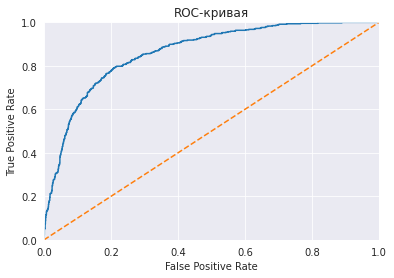

In [167]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_test[:, 1]) 

#  график 
plt.figure()
plt.plot(fpr, tpr)

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

# границы осей от 0 до 1 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title(label='ROC-кривая')
plt.show()

➡️ Видно, что наша модель сильно отличается от случайной.

<font color='blue' size=3><b>Матрица ошибок</b></font> 

In [168]:
confusion_matrix(target_test, predicted_test)

array([[1204,   88],
       [ 231,  235]])

In [169]:
def plot_confusion_matrix_illustration():
    plt.figure(figsize=(6, 4))
    confusion = confusion_matrix(target_test, predicted_test)
    plt.text(0.40, .7, confusion[0, 0], size=20, horizontalalignment='right')
    plt.text(0.40, .2, confusion[1, 0], size=20, horizontalalignment='right')
    plt.text(.90, .7, confusion[0, 1], size=20, horizontalalignment='right')
    plt.text(.90, 0.2, confusion[1, 1], size=20, horizontalalignment='right')
    plt.xticks([.25, .75], ["Предсказание 0'", "Предсказание 1'"], size=15)
    plt.yticks([.25, .75], ["Ответы 1", "Ответы 0"], size=15)
    plt.plot([.5, .5], [0, 1], '--', c='k')
    plt.plot([0, 1], [.5, .5], '--', c='k')

    plt.xlim(0, 1)
    plt.ylim(0, 1)

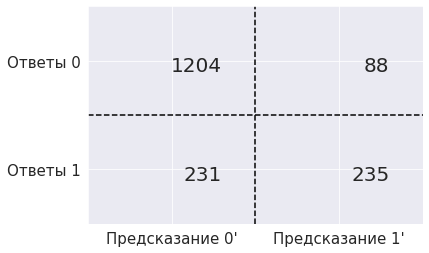

In [170]:
plot_confusion_matrix_illustration()

➡️ Так как нам необходимо узнать уйдет ли клиент, нам важны истино-положительные и ложно-положительные показатели. Матрица ошибок показывает, что из всех предсказанных оценок, что клиент уйдет - 88 ошибок, что соответствует 27% ошибок. На мой взгляд это довольно много. Это показывает, скорее всего, проблему в наборе данных - они не влияют на уход клиентов, что также показала корреляция.

<font color='blue' size=3><b>Полнота и точность модели на графике.</b></font> 

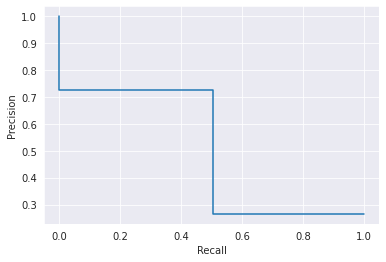

In [171]:
precision, recall, _ = precision_recall_curve(target_test, predicted_test)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot();

➡️ При средней полноте, точность не высокая.

<font color='blue' size=3><b>Важность основных входных признаков, влияющих на отток клиентов</b></font> 

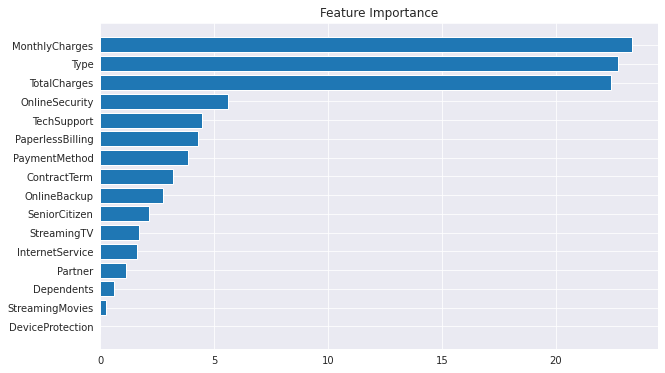

In [172]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features_test.columns)[sorted_idx])
plt.title('Feature Importance');

➡️ Самыми важными признаками оказались: ежемесячный платеж, тип оплаты и общая сумма расхода по клиенту.

<font color='blue' size=3><b>График зависимости входного и целевого признаков.</b></font> 

Дополнительное исследование для одного из важных входных признаков.
График зависимости входного и целевого признаков.

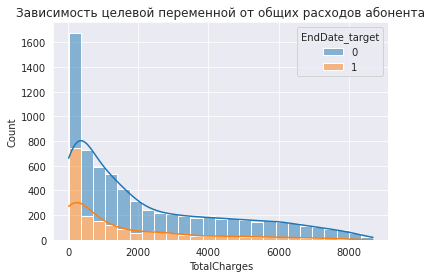

In [173]:
sns.histplot(data=data_final, 
             x="TotalCharges", 
             hue="EndDate_target", 
             multiple="stack", 
             kde=True).set_title('Зависимость целевой переменной от общих расходов абонента');

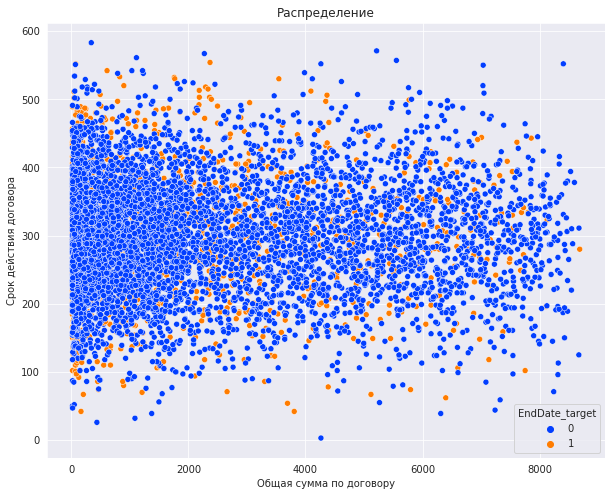

In [174]:
# вывод графика распределения целевого признака по сроку действия договора и сумме по договору
plt.figure(figsize=(10, 8))
ax = sns.scatterplot(
    data=data_final, 
    y='ContractTerm', 
    x='TotalCharges',
    palette="bright",
    hue='EndDate_target'
)
ax.set_title('Распределение')
ax.set_xlabel('Общая сумма по договору')
ax.set_ylabel('Срок действия договора');

➡️ На графике зависимости целевой переменной от общих расходов абонента видно, что распределения для двух типов клиентов (ушел/остался) повторяют друг друга, отличаются только количеством клиентов. Клиентов, которые заплатили за весь период договора минимальную сумму больше всех.

# Общий вывод по работе

Общие выводы, способы для дальнейшего улучшения модели и бизнес-рекомендации заказчику.

<font color='blue' size=4><b>Выводы:</b></font> 

В данном проекте необходимо было обучить на имеющихся данных модель для прогноза оттока клиентов.

Полученные данные были загружены, обработаны, проведен первичный анализ данных и, затем, данные объединены в одну финальную таблицу. Был добавлен признак - срок действия договора, а так же добавлен целевой признак: клиент ушел - 1, клиент остался - 0.

Общая таблица так же была проанализирована и выявлены некоторые особенности входящих признаков:
- Клиенты, которые платят раз в два года или раз в год, разрывают договор реже, чем те кто платит ежемесячно.
- Клиенты, получающие электронные квитанции, чаще разрывают контракт.
- Среди клиентов, разорвавших контракт, большинство расплачиваются кредитной картой.
- Клиенты, которые расторгли договор, в среднем за месяц платили больше.
- Клиенты, которые расторгли договор, имеют общие расходы меньше. Но эти данные не сишком информативны, так как это, возможно, связано с тем, что клиенты, которые остались платили дольше по времени.
- Среднее количество дней, в течении которого длится контракт примерно одинаковое у обоих типов клиентов.
- Пенсионеров среди клиентов мало.
- Клиентов, имеющих супруга больше среди тех, кто остался клиентом компании. Тогда как среди тех, кто расторг договор, больше клиентов, которые не имеют супруга.
- Клиентов, у которых есть дети, меньше.
- Среди клиентов, которые покинули компанию, больше тех, которые используют оптоволоконный тип подключения. Возможно, есть какая-то проблема с этом типом подключения. Среди тех, кто остался, больше тех, которые используют DSL.
- Клиенты, которые пользуются подключением телефона к нескольким линиям одновременно, реже уходят.
- Клиенты, которые пользуются выделенной линии технической поддержки, реже уходят.

Установлено, что все признаки имеют либо слабую, либо нулевую корреляцию.

Для целей обучения, данные разделены на выборки, закодированы.

Обучили шесть моделей LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, CatBoostClassifier, LGBMClassifier, полносвязная нейронная Net.

Для тестирования на тестовой выборке выбрана модель CatBoostClassifier, которая показывает метрику ROC_AUC - 0.84.

На тестовой выборке модель показала себя немного лучше и преодолела заданный порог ROC_AUC = 0.86. Accuracy на тестовой выборке: 0.82, что означает, что доля правильных ответов составляет 82%. Построена ROC-кривая, на которой видно, что модель отличается от случайной. Матрица ошибок показывает не самые лучшие результаты: из предсказанных оценок, что клиент уйдет - ошибочныйх 27%. Это показывает, скорее всего, проблему в наборе данных - они не влияют на уход клиентов, что также показала корреляция.

Установлена важность признаков, влияющих на отток клиентов. Самыми важными признаками оказались: ежемесячный платеж, тип оплаты и общая сумма расхода по клиенту.

<font color='blue' size=4><b>Бизнес-рекомендации заказчику.</b></font> 

На мой взгляд, предоставленных данных не достаточно для создания точной модели. Для того, чтобы предсказать уход клиента, необходимо проанализировать признаки, которые на самом деле влияют на уход клиента. Важнейшим показателем является причина ухода. Хорошим решением было вы выяснять, по какой причине уходит каждый конкретный клиент, вести этот учет и одновременно предложить клиенту решить его проблему, если это возможно или предложить скидки или спец.предложения, если проблему решать уже поздно и необходимо повысить лояльность клиента.

Косвенными признаками могут быть: количество обращений клиента с жалобами по качеству связи или интернета,  удовлетворенность абонента качеством работы тех.поддержки и т.п. Так же важным факоторм может стать стоимость тарифов относительно других операторов. Эти данные можно собирать дополнительно.